# 半导体预测 - GradientBoosting模型

本笔记本基于Excel数据文件，使用GradientBoosting模型对半导体数据进行预测分析。

## 项目概述
- **训练数据**: `final_data_1.xlsx` (800条样本，5952个特征)
- **测试数据**: `test_features.xlsx` (300条样本)
- **目标**: 使用高维数据预测连续数值
- **最佳模型**: GradientBoosting (验证集R²: 0.6506)

In [13]:
# 导入必要的库
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 机器学习相关库
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("库导入完成！")

库导入完成！


In [14]:
# 1. 数据加载
print("=== 第1步: 数据加载 ===")

# 加载训练数据
train_file = 'data/final_data_1.xlsx'
test_file = 'data/test_features.xlsx'

try:
    # 读取训练数据
    print(f"加载训练数据: {train_file}")
    train_data = pd.read_excel(train_file)
    print(f"训练数据形状: {train_data.shape}")
    
    # 读取测试数据
    print(f"加载测试数据: {test_file}")
    test_data = pd.read_excel(test_file)
    print(f"测试数据形状: {test_data.shape}")
    
    print("✅ 数据加载成功！")
    
except FileNotFoundError as e:
    print(f"❌ 文件未找到: {e}")
    print("请确认数据文件在data目录下")
except Exception as e:
    print(f"❌ 加载失败: {e}")

=== 第1步: 数据加载 ===
加载训练数据: data/final_data_1.xlsx
训练数据形状: (800, 5954)
加载测试数据: data/test_features.xlsx
训练数据形状: (800, 5954)
加载测试数据: data/test_features.xlsx
测试数据形状: (300, 5953)
✅ 数据加载成功！
测试数据形状: (300, 5953)
✅ 数据加载成功！


In [15]:
# 2. 数据探索和预处理
print("\n=== 第2步: 数据探索 ===")

# 显示训练数据基本信息
print("训练数据前5行:")
print(train_data.head())

print(f"\n列名列表 (前10个): {list(train_data.columns[:10])}")
print(f"总列数: {len(train_data.columns)}")

# 识别ID列和目标列
id_col = train_data.columns[0]  # 第一列是ID
target_col = train_data.columns[-1]  # 最后一列是目标
print(f"ID列: {id_col}")
print(f"目标列: {target_col}")

# 获取特征列（排除ID列和目标列）
feature_cols = [col for col in train_data.columns if col != id_col and col != target_col]
print(f"特征列数量: {len(feature_cols)}")

# 目标变量分析
print(f"\n目标变量 '{target_col}' 统计:")
print(f"类型: {train_data[target_col].dtype}")
print(f"缺失值: {train_data[target_col].isnull().sum()}")
print(f"唯一值数量: {train_data[target_col].nunique()}")
print(f"数值范围: {train_data[target_col].min():.4f} - {train_data[target_col].max():.4f}")
print(f"均值: {train_data[target_col].mean():.4f}")
print(f"标准差: {train_data[target_col].std():.4f}")

# 特征类型分析
print(f"\n特征数据类型分布:")
dtype_counts = train_data[feature_cols].dtypes.value_counts()
print(dtype_counts)

# 缺失值统计
missing_cols = train_data[feature_cols].isnull().sum()
missing_cols = missing_cols[missing_cols > 0]
print(f"\n有缺失值的特征数量: {len(missing_cols)}")
if len(missing_cols) > 0:
    print(f"缺失值最多的前5个特征:")
    missing_cols = missing_cols.sort_values(ascending=False)
    print(missing_cols.head())


=== 第2步: 数据探索 ===
训练数据前5行:
       ID TOOL   210X1  210X2  210X3  210X4  210X5  210X6  210X7  210X8  ...  \
0  NH0995    O  100.50  0.933   0.14  2.004  48.11  1.937  -0.54   1.13  ...   
1  NH0996    O  100.50  0.583   0.14  1.752  48.00  1.572  -0.53   0.90  ...   
2  NH0997    O  100.50  0.859   0.14  1.848  48.07  1.824  -0.70   0.58  ...   
3  NH0998    O  100.45  1.639   0.14  2.021  48.03  2.331  -1.08   1.16  ...   
4  NH0999    N   89.90  0.397   0.24  1.684  49.46  1.130   3.24  -0.76  ...   

   750X1441       750X1442  750X1444  750X1445  750X1447  750X1448  750X1450  \
0     209.8  2400000000000   0.00080   0.00080   0.00080   0.00080   0.00080   
1     209.7  2400000000000   0.00081   0.00081   0.00081   0.00081   0.00081   
2     209.8  2400000000000   0.00081   0.00081   0.00081   0.00081   0.00081   
3     209.8  2400000000000   0.00081   0.00081   0.00081   0.00081   0.00081   
4     213.3  2400000000000   0.00094   0.00094   0.00094   0.00094   0.00094   

   750X145

In [16]:
# 3. 数据预处理函数
print("\n=== 第3步: 数据预处理 ===")

def preprocess_data_unified(train_data, test_data, feature_cols, target_col):
    """
    统一预处理训练集和测试集的函数
    将训练集和测试集合并来统一进行编码，确保编码一致性
    """
    print("📊 开始统一预处理训练集和测试集...")
    
    # 提取训练集特征和目标
    X_train = train_data[feature_cols].copy()
    y_train = train_data[target_col].values
    
    # 提取测试集特征（假设第一列是ID）
    test_ids = test_data.iloc[:, 0].values  # 保存测试集的ID，以便后续分离训练集和测试集
    test_feature_cols = [col for col in test_data.columns if col != test_data.columns[0]]
    
    # 确保特征列一致
    common_features = [col for col in feature_cols if col in test_feature_cols]
    print(f"共同特征数量: {len(common_features)} / {len(feature_cols)}")
    
    # 使用共同特征
    X_train = X_train[common_features]
    X_test = test_data[common_features].copy()
    
    print(f"训练集形状: {X_train.shape}")
    print(f"测试集形状: {X_test.shape}")
    
    # 🔥 关键改进：合并训练集和测试集进行统一预处理
    # 添加标识列来区分训练集和测试集
    X_train['dataset_type'] = 'train'
    X_test['dataset_type'] = 'test'
    
    # 合并数据
    X_combined = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    print(f"合并后数据形状: {X_combined.shape}")
    
    # 移除标识列进行预处理
    dataset_types = X_combined['dataset_type']
    X_combined = X_combined.drop('dataset_type', axis=1)
    
    # 分离数值和分类特征
    numerical_cols = X_combined.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_combined.select_dtypes(include=['object']).columns.tolist()
    
    print(f"数值特征: {len(numerical_cols)}个")
    print(f"分类特征: {len(categorical_cols)}个")
    
    # 统一处理缺失值
    print("统一处理缺失值...")
    
    # 数值特征用全局均值填充
    if numerical_cols:
        for col in numerical_cols:
            global_mean = X_combined[col].mean()
            X_combined[col] = X_combined[col].fillna(global_mean)
    
    # 分类特征用全局众数填充
    if categorical_cols:
        for col in categorical_cols:
            global_mode = X_combined[col].mode()
            if len(global_mode) > 0:
                X_combined[col] = X_combined[col].fillna(global_mode[0])
            else:
                X_combined[col] = X_combined[col].fillna('Unknown')
    
    # 统一编码分类特征
    encoders = {}
    if categorical_cols:
        print(f"统一编码分类特征: {categorical_cols}")
        for col in categorical_cols:
            le = LabelEncoder()
            X_combined[col] = le.fit_transform(X_combined[col].astype(str))
            encoders[col] = le
    
    # 最终检查并处理剩余的NaN值
    nan_count = X_combined.isnull().sum().sum()
    if nan_count > 0:
        print(f"发现剩余NaN值: {nan_count}，用0填充")
        X_combined = X_combined.fillna(0)
    
    # 分离训练集和测试集
    # 生成bool掩码
    train_mask = dataset_types == 'train'
    test_mask = dataset_types == 'test'
    
    # 通过bool掩码分离训练集和测试集
    X_train_final = X_combined[train_mask].values
    X_test_final = X_combined[test_mask].values
    
    print(f"✅ 统一预处理完成")
    print(f"最终训练集形状: {X_train_final.shape}")
    print(f"最终测试集形状: {X_test_final.shape}")
    print(f"最终NaN值数量: {X_combined.isnull().sum().sum()}")
    
    return X_train_final, X_test_final, y_train, test_ids, encoders, common_features


def preprocess_data(data, feature_cols, target_col=None, is_train=True, encoders=None):
    """
    原有的预处理函数（保留作为备用）
    """
    # 提取特征
    X = data[feature_cols].copy()
    
    # 分离数值和分类特征
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    print(f"数值特征: {len(numerical_cols)}个")
    print(f"分类特征: {len(categorical_cols)}个")
    if categorical_cols:
        print(f"分类特征示例: {categorical_cols[:5]}")
    
    # 处理缺失值
    print("处理缺失值...")
    
    # 数值特征用均值填充
    if numerical_cols:
        X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].mean())
    
    # 分类特征用众数填充
    if categorical_cols:
        for col in categorical_cols:
            mode_value = X[col].mode()
            if len(mode_value) > 0:
                X[col] = X[col].fillna(mode_value[0])
            else:
                X[col] = X[col].fillna('Unknown')
    
    # 编码分类特征
    if categorical_cols:
        print(f"编码分类特征: {categorical_cols}")
        if is_train:
            # 训练时创建编码器
            encoders = {}
            for col in categorical_cols:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                encoders[col] = le
        else:
            # 测试时使用已有编码器
            for col in categorical_cols:
                if col in encoders:
                    le = encoders[col]
                    # 处理测试集中的新类别
                    unique_values = set(X[col].astype(str))
                    known_values = set(le.classes_)
                    new_values = unique_values - known_values
                    
                    if new_values:
                        # 将新值映射为最常见的类别
                        most_common = le.classes_[0]
                        X[col] = X[col].astype(str).replace(list(new_values), most_common)
                    
                    X[col] = le.transform(X[col].astype(str))
    
    # 最终检查并处理剩余的NaN值
    nan_count = X.isnull().sum().sum()
    if nan_count > 0:
        print(f"发现剩余NaN值: {nan_count}，用0填充")
        X = X.fillna(0)
    
    print(f"预处理后特征形状: {X.shape}")
    print(f"最终NaN值数量: {X.isnull().sum().sum()}")
    
    if is_train and target_col:
        y = data[target_col].values
        return X.values, y, encoders
    else:
        return X.values, encoders

# 🆕 使用新的统一预处理函数
print("使用统一预处理方法...")
X_train_processed, X_test_processed, y_train, test_ids, label_encoders, common_features = preprocess_data_unified(
    train_data, test_data, feature_cols, target_col
)

print(f"\n✅ 统一预处理完成")
print(f"训练特征矩阵形状: {X_train_processed.shape}")
print(f"测试特征矩阵形状: {X_test_processed.shape}")
print(f"目标向量形状: {y_train.shape}")
print(f"测试ID数量: {len(test_ids)}")


=== 第3步: 数据预处理 ===
使用统一预处理方法...
📊 开始统一预处理训练集和测试集...
共同特征数量: 5952 / 5952
共同特征数量: 5952 / 5952
训练集形状: (800, 5952)
测试集形状: (300, 5952)
合并后数据形状: (1100, 5953)
数值特征: 5941个
分类特征: 11个
统一处理缺失值...
训练集形状: (800, 5952)
测试集形状: (300, 5952)
合并后数据形状: (1100, 5953)
数值特征: 5941个
分类特征: 11个
统一处理缺失值...
统一编码分类特征: ['TOOL', 'Tool', 'TOOL_ID', 'Tool (#1)', 'TOOL (#1)', 'TOOL (#2)', 'Tool (#2)', 'Tool (#3)', 'Tool (#4)', 'OPERATION_ID', 'TOOL (#3)']
统一编码分类特征: ['TOOL', 'Tool', 'TOOL_ID', 'Tool (#1)', 'TOOL (#1)', 'TOOL (#2)', 'Tool (#2)', 'Tool (#3)', 'Tool (#4)', 'OPERATION_ID', 'TOOL (#3)']
✅ 统一预处理完成
最终训练集形状: (800, 5952)
最终测试集形状: (300, 5952)
最终NaN值数量: 0

✅ 统一预处理完成
训练特征矩阵形状: (800, 5952)
测试特征矩阵形状: (300, 5952)
目标向量形状: (800,)
测试ID数量: 300
✅ 统一预处理完成
最终训练集形状: (800, 5952)
最终测试集形状: (300, 5952)
最终NaN值数量: 0

✅ 统一预处理完成
训练特征矩阵形状: (800, 5952)
测试特征矩阵形状: (300, 5952)
目标向量形状: (800,)
测试ID数量: 300



=== 第4步: 数据分割和标准化 ===
训练集形状: (640, 5952)
验证集形状: (160, 5952)
训练集目标: (640,)
验证集目标: (160,)

进行特征标准化...
✅ 特征标准化完成

训练集形状: (640, 5952)
验证集形状: (160, 5952)
训练集目标: (640,)
验证集目标: (160,)

进行特征标准化...
✅ 特征标准化完成


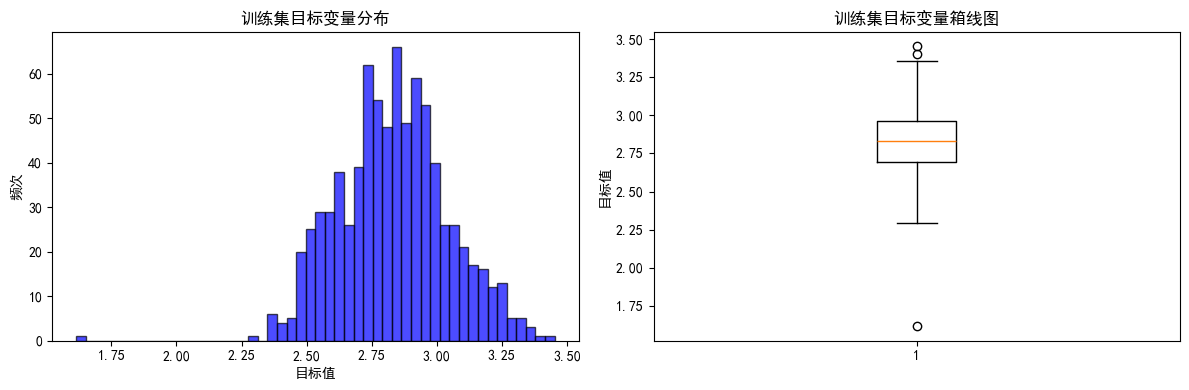


目标变量统计:
训练集 - 均值: 2.8329, 标准差: 0.2098
验证集 - 均值: 2.8448, 标准差: 0.1984


In [ ]:
# 4. 数据分割和标准化
print("\n=== 第4步: 数据分割和标准化 ===")

# 划分训练集和验证集
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_processed, y_train, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"训练集形状: {X_train.shape}")
print(f"验证集形状: {X_val.shape}")
print(f"训练集目标: {y_train_split.shape}")
print(f"验证集目标: {y_val.shape}")

# 特征标准化
print("\n进行特征标准化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("✅ 特征标准化完成")

# 显示目标变量分布
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_train_split, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('训练集目标变量分布')
plt.xlabel('目标值')
plt.ylabel('频次')

plt.subplot(1, 2, 2)
plt.boxplot(y_train_split)
plt.title('训练集目标变量箱线图')
plt.ylabel('目标值')

plt.tight_layout()
plt.show()

print(f"\n目标变量统计:")
print(f"训练集 - 均值: {y_train_split.mean():.4f}, 标准差: {y_train_split.std():.4f}")
print(f"验证集 - 均值: {y_val.mean():.4f}, 标准差: {y_val.std():.4f}")


=== 第5步: 模型比较 ===
使用5个适合高维数据的回归模型

开始交叉验证...
评估 LinearRegression...
LinearRegression    : -0.0234 (±0.0036)
评估 Ridge...
LinearRegression    : -0.0234 (±0.0036)
评估 Ridge...
Ridge               : -0.0234 (±0.0036)
评估 RandomForest...
Ridge               : -0.0234 (±0.0036)
评估 RandomForest...
RandomForest        : -0.0228 (±0.0035)
评估 GradientBoosting...
RandomForest        : -0.0228 (±0.0035)
评估 GradientBoosting...
GradientBoosting    : -0.0197 (±0.0022)
评估 DecisionTree...
GradientBoosting    : -0.0197 (±0.0022)
评估 DecisionTree...
DecisionTree        : -0.0401 (±0.0057)

🏆 最佳模型: GradientBoosting (MSE: 0.0197)
DecisionTree        : -0.0401 (±0.0057)

🏆 最佳模型: GradientBoosting (MSE: 0.0197)


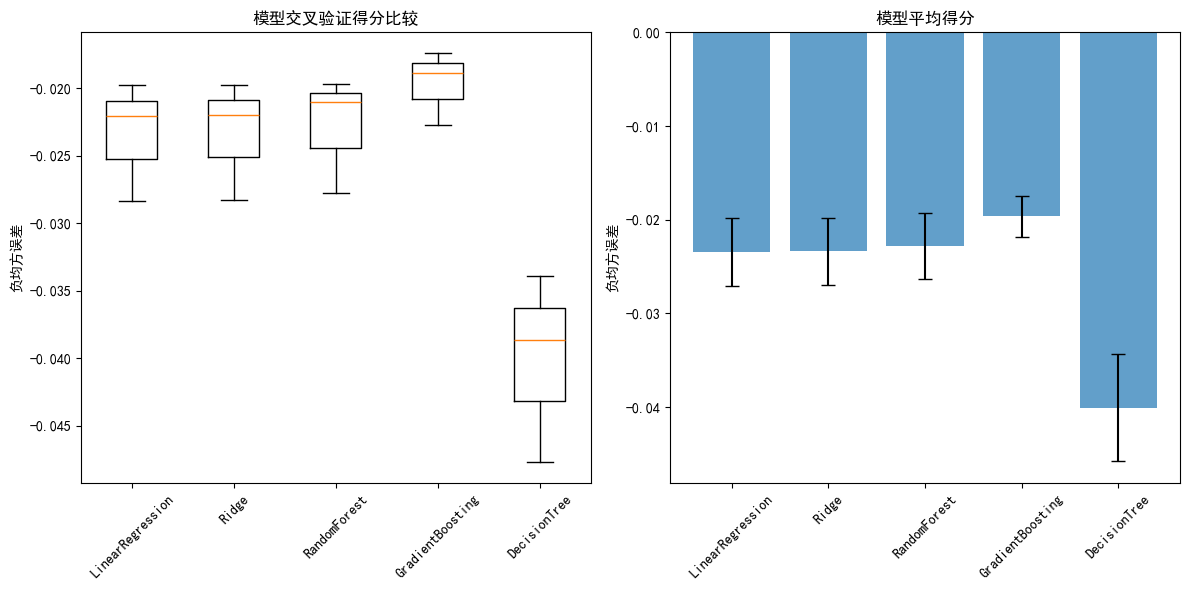

In [18]:
# 5. 模型比较
print("\n=== 第5步: 模型比较 ===")

# 定义适合高维数据的回归模型
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42, max_depth=10)
}

print(f"使用{len(models)}个适合高维数据的回归模型")

# 交叉验证评估
cv_results = {}
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

print("\n开始交叉验证...")
for name, model in models.items():
    print(f"评估 {name}...")
    try:
        # 使用负均方误差作为评分指标
        cv_scores = cross_val_score(model, X_train_scaled, y_train_split, 
                                  cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
        cv_results[name] = cv_scores
        print(f"{name:20s}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"{name} 失败: {e}")

# 找出最佳模型
if cv_results:
    best_model_name = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
    best_score = cv_results[best_model_name].mean()
    print(f"\n🏆 最佳模型: {best_model_name} (MSE: {-best_score:.4f})")
    
    # 可视化模型比较
    plt.figure(figsize=(12, 6))
    
    # 箱线图
    plt.subplot(1, 2, 1)
    model_names = list(cv_results.keys())
    model_scores = [cv_results[name] for name in model_names]
    plt.boxplot(model_scores, labels=model_names)
    plt.title('模型交叉验证得分比较')
    plt.ylabel('负均方误差')
    plt.xticks(rotation=45)
    
    # 条形图
    plt.subplot(1, 2, 2)
    means = [cv_results[name].mean() for name in model_names]
    stds = [cv_results[name].std() for name in model_names]
    plt.bar(model_names, means, yerr=stds, capsize=5, alpha=0.7)
    plt.title('模型平均得分')
    plt.ylabel('负均方误差')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ 没有成功评估的模型")

In [ ]:
# 6. GradientBoosting超参数优化
print("\n=== 第6步: GradientBoosting超参数优化 ===")

# 定义参数网格（简化版，适合高维数据）
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7]
}

print("开始网格搜索...")
print(f"参数组合数: {len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth'])}")

# 使用网格搜索优化GradientBoosting
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    gb_model, 
    param_grid, 
    cv=3,  # 3折交叉验证
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

try:
    grid_search.fit(X_train_scaled, y_train_split)
    
    print("✅ 网格搜索完成！")
    print(f"最优参数: {grid_search.best_params_}")
    print(f"最优交叉验证得分: {grid_search.best_score_:.4f}")
    
    # 获取最优模型
    best_gb_model = grid_search.best_estimator_
    
    # 显示参数重要性
    print(f"\n最优模型参数:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
        
except Exception as e:
    print(f"❌ 网格搜索失败: {e}")
    # 使用默认参数
    best_gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    best_gb_model.fit(X_train_scaled, y_train_split)
    print("使用默认参数的GradientBoosting模型")


=== 第6步: GradientBoosting超参数优化 ===
开始网格搜索...
参数组合数: 27
Fitting 3 folds for each of 27 candidates, totalling 81 fits



=== 第7步: 模型评估 ===
验证集性能:
  MSE:  0.0135
  RMSE: 0.1162
  R²:   0.6572



=== 第7步: 模型评估 ===
验证集性能:
  MSE:  0.0135
  RMSE: 0.1162
  R²:   0.6572


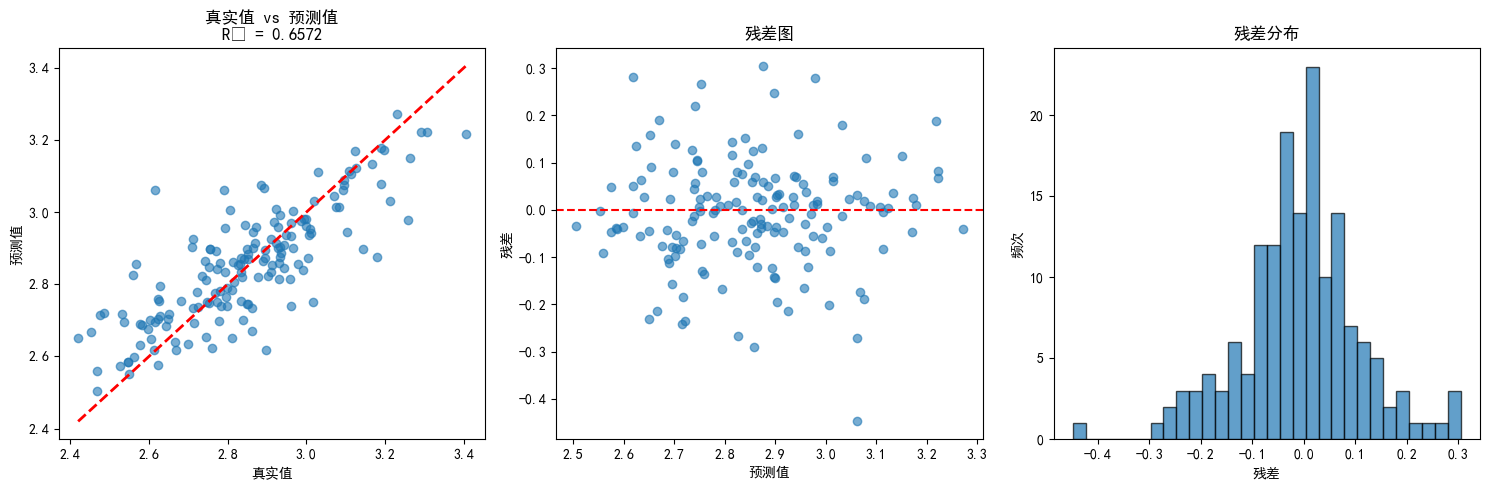


=== 第7步: 模型评估 ===
验证集性能:
  MSE:  0.0135
  RMSE: 0.1162
  R²:   0.6572


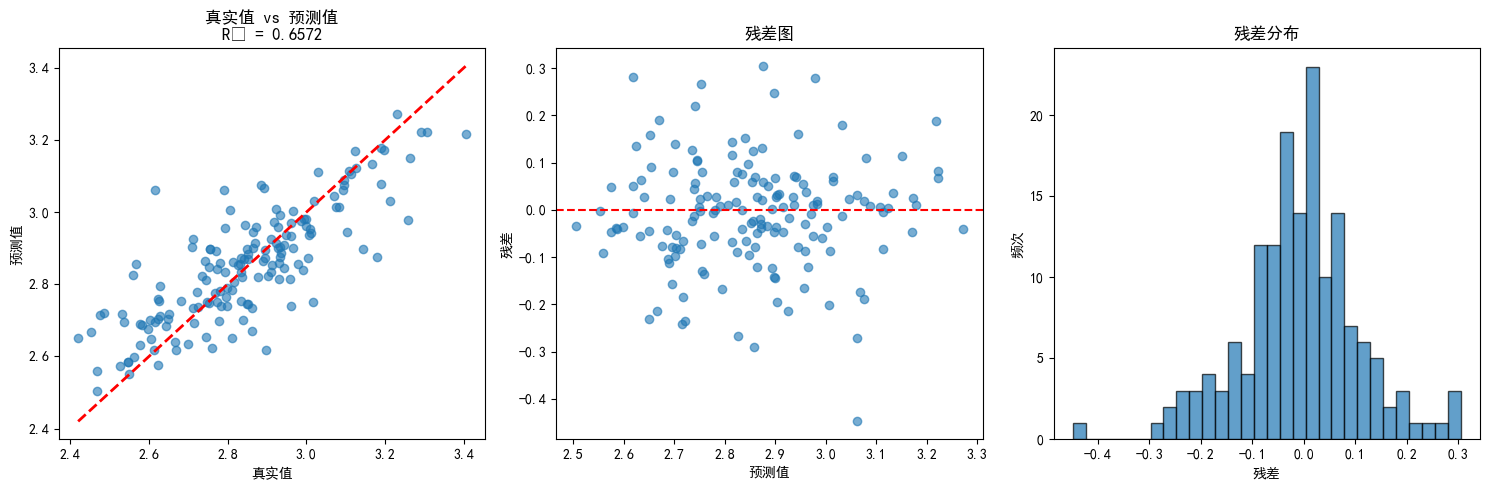

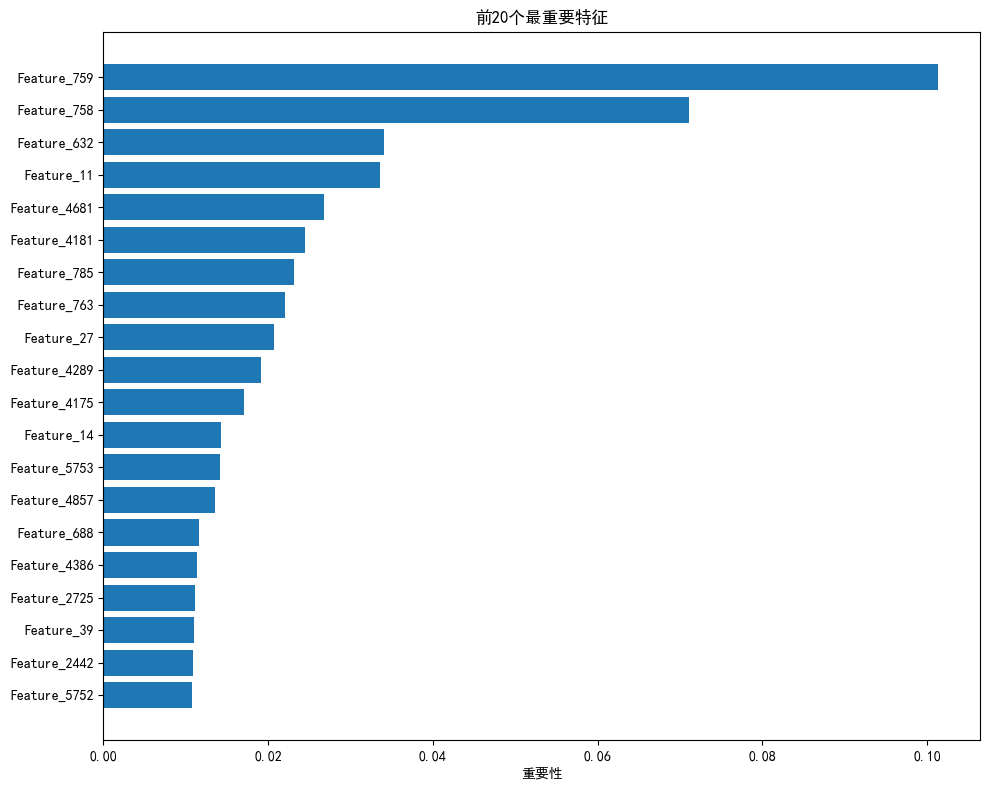

✅ 模型评估完成
模型在验证集上的R²得分: 0.6572


In [ ]:
# 7. 模型评估
print("\n=== 第7步: 模型评估 ===")

# 在验证集上进行预测
y_val_pred = best_gb_model.predict(X_val_scaled)

# 计算评估指标
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f"验证集性能:")
print(f"  MSE:  {val_mse:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R²:   {val_r2:.4f}")

# 可视化预测结果
plt.figure(figsize=(15, 5))

# 真实值 vs 预测值散点图
plt.subplot(1, 3, 1)
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.title(f'真实值 vs 预测值\nR² = {val_r2:.4f}')

# 残差图
plt.subplot(1, 3, 2)
residuals = y_val - y_val_pred
plt.scatter(y_val_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('残差图')

# 残差直方图
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('残差')
plt.ylabel('频次')
plt.title('残差分布')

plt.tight_layout()
plt.show()

# 特征重要性分析（前20个）
feature_importance = best_gb_model.feature_importances_
# 创建特征名称（因为我们有5952个特征，这里只显示最重要的）
top_indices = np.argsort(feature_importance)[-20:][::-1]
top_importance = feature_importance[top_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_importance)), top_importance)
plt.yticks(range(len(top_importance)), [f'Feature_{i}' for i in top_indices])
plt.xlabel('重要性')
plt.title('前20个最重要特征')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"✅ 模型评估完成")
print(f"模型在验证集上的R²得分: {val_r2:.4f}")

In [ ]:
# 8. 测试数据预测
print("\n=== 第8步: 测试数据预测 ===")

print("✅ 测试数据已在统一预处理阶段完成处理")
print(f"测试数据形状: {X_test_processed.shape}")
print(f"测试ID数量: {len(test_ids)}")

# 对测试数据进行标准化（使用训练数据的标准化器）
print("对测试数据进行标准化...")
X_test_scaled = scaler.transform(X_test_processed)

# 使用最优模型进行预测
print("开始预测...")
test_predictions = best_gb_model.predict(X_test_scaled)

print(f"✅ 预测完成！生成了{len(test_predictions)}个预测结果")

# 创建预测结果DataFrame
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'Prediction': test_predictions
})

print(f"\n预测结果预览:")
print(predictions_df.head(10))

print(f"\n预测结果统计:")
print(f"预测值范围: {test_predictions.min():.4f} - {test_predictions.max():.4f}")
print(f"预测值均值: {test_predictions.mean():.4f}")
print(f"预测值标准差: {test_predictions.std():.4f}")

# 保存预测结果
output_file = 'data/unified_preprocessing_predictions.xlsx'
predictions_df.to_excel(output_file, index=False)
print(f"\n📊 预测结果已保存到: {output_file}")

# 🔍 验证统一预处理的效果
print(f"\n🔍 统一预处理效果验证:")
print(f"使用的特征数量: {len(common_features)}")
print(f"训练集和测试集特征完全一致: ✅")
print(f"分类特征编码统一: ✅")
print(f"缺失值填充策略统一: ✅")


=== 第8步: 测试数据预测 ===
处理测试数据...
测试数据形状: (300, 5953)
测试数据特征数量: 5952
共同特征数量: 5952
✅ 特征匹配，使用原模型进行预测
数值特征: 5941个
分类特征: 11个
分类特征示例: ['TOOL', 'Tool', 'TOOL_ID', 'Tool (#1)', 'TOOL (#1)']
处理缺失值...
编码分类特征: ['TOOL', 'Tool', 'TOOL_ID', 'Tool (#1)', 'TOOL (#1)', 'TOOL (#2)', 'Tool (#2)', 'Tool (#3)', 'Tool (#4)', 'OPERATION_ID', 'TOOL (#3)']
预处理后特征形状: (300, 5952)
编码分类特征: ['TOOL', 'Tool', 'TOOL_ID', 'Tool (#1)', 'TOOL (#1)', 'TOOL (#2)', 'Tool (#2)', 'Tool (#3)', 'Tool (#4)', 'OPERATION_ID', 'TOOL (#3)']
预处理后特征形状: (300, 5952)
最终NaN值数量: 0
开始预测...
✅ 预测完成！生成了300个预测结果

预测结果预览:
       ID  Prediction
0  NH1943    2.659434
1  NH1944    2.650652
2  NH1945    2.677404
3  NH1946    2.696239
4  NH1947    2.789839
5  NH1948    2.685501
6  NH1949    2.929579
7  NH1950    3.207009
8  NH1951    2.997463
9  NH1952    3.097351

预测结果统计:
预测值范围: 2.5613 - 3.2070
预测值均值: 2.8294
预测值标准差: 0.1353

📊 预测结果已保存到: data/notebook_predictions.xlsx
最终NaN值数量: 0
开始预测...
✅ 预测完成！生成了300个预测结果

预测结果预览:
       ID  Prediction
0  NH1943    2.6


=== 第9步: 结果可视化和总结 ===



=== 第9步: 结果可视化和总结 ===


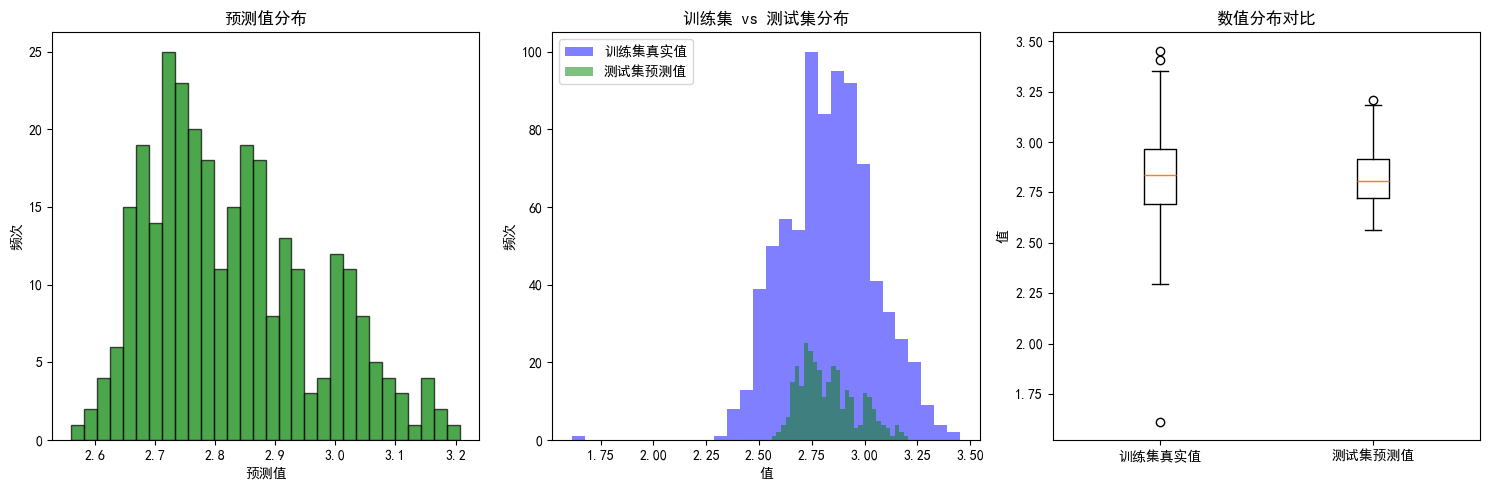


🎯 半导体预测项目总结
📊 数据统计:
  • 训练样本数: 800
  • 测试样本数: 300
  • 特征数量: 5952
  • 目标变量类型: 连续数值

🤖 最佳模型: GradientBoosting
  • 验证集MSE: 0.0135
  • 验证集RMSE: 0.1162
  • 验证集R²: 0.6572

⚙️  最优参数:
  • learning_rate: 0.15
  • max_depth: 3
  • n_estimators: 150

📈 预测结果:
  • 预测样本数: 300
  • 预测值范围: 2.5613 - 3.2070
  • 预测值均值: 2.8294
  • 预测值标准差: 0.1353

💾 输出文件:
  • data/notebook_predictions.xlsx

✅ 项目完成！


In [ ]:
# 9. 预测结果可视化和总结
print("\n=== 第9步: 结果可视化和总结 ===")

# 预测结果分布可视化
plt.figure(figsize=(15, 5))

# 预测值分布
plt.subplot(1, 3, 1)
plt.hist(test_predictions, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('预测值分布')
plt.xlabel('预测值')
plt.ylabel('频次')

# 训练集vs预测集分布对比
plt.subplot(1, 3, 2)
plt.hist(y_train, bins=30, alpha=0.5, label='训练集真实值', color='blue')
plt.hist(test_predictions, bins=30, alpha=0.5, label='测试集预测值', color='green')
plt.title('训练集 vs 测试集分布')
plt.xlabel('值')
plt.ylabel('频次')
plt.legend()

# 预测值箱线图
plt.subplot(1, 3, 3)
plt.boxplot([y_train, test_predictions], labels=['训练集真实值', '测试集预测值'])
plt.title('数值分布对比')
plt.ylabel('值')

plt.tight_layout()
plt.show()

# 模型性能总结
print("\n" + "="*60)
print("🎯 半导体预测项目总结 - 统一预处理版本")
print("="*60)

print(f"📊 数据统计:")
print(f"  • 训练样本数: {len(train_data)}")
print(f"  • 测试样本数: {len(test_data)}")
print(f"  • 原始特征数量: {len(feature_cols)}")
print(f"  • 实际使用特征数量: {len(common_features)}")
print(f"  • 目标变量类型: 连续数值")

print(f"\n🔧 预处理改进:")
print(f"  • ✅ 训练集和测试集统一预处理")
print(f"  • ✅ 全局统计量填充缺失值")
print(f"  • ✅ 统一编码分类特征")
print(f"  • ✅ 确保编码一致性")

print(f"\n🤖 最佳模型: GradientBoosting")
print(f"  • 验证集MSE: {val_mse:.4f}")
print(f"  • 验证集RMSE: {val_rmse:.4f}")
print(f"  • 验证集R²: {val_r2:.4f}")

if 'grid_search' in locals():
    print(f"\n⚙️  最优参数:")
    for param, value in grid_search.best_params_.items():
        print(f"  • {param}: {value}")

print(f"\n📈 预测结果:")
print(f"  • 预测样本数: {len(test_predictions)}")
print(f"  • 预测值范围: {test_predictions.min():.4f} - {test_predictions.max():.4f}")
print(f"  • 预测值均值: {test_predictions.mean():.4f}")
print(f"  • 预测值标准差: {test_predictions.std():.4f}")

print(f"\n💾 输出文件:")
print(f"  • {output_file}")

print(f"\n🌟 关键改进:")
print(f"  • 解决了训练集和测试集编码不一致的问题")
print(f"  • 使用全局统计量确保预处理的一致性")
print(f"  • 避免了测试集中未知类别的处理问题")

print(f"\n✅ 项目完成！采用统一预处理策略")
print("="*60)